# Image Resizing

<br/>

<pre>
dataset:      imagewoof
resizing to:  128x128
</pre>

<br/>

We want to test our Out-of-Distribution (OoD) detection method __Layer-wise Activation Cluster Analysis (LACA)__ on a dataset that is more complex than the MNIST, SVHN or the CIFAR-10 dataset which have been used so far. We chose the [Imagewoof dataset](https://github.com/fastai/imagenette) as it contains images showing more complex scenes. The [Imagewoof dataset](https://github.com/fastai/imagenette) is a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). 

For training the model and applying our OoD detection method we need an equal size of all images. However, the images of the [Imagewoof dataset](https://github.com/fastai/imagenette) are of different sizes. Thus, we need to resize all images of the dataset beforehand. However, an image size that is too small might result in losing important details of the image. Moreover, we also want to show that our method works on larger images than images from MNIST (image size: 28x28), SVHN (image size: 32x32) or CIFAR-10 (image size: 32x32). Thus, we chose an image size of 128x128. For now we do not want to go larger as this might later result into memory problems when generating the activations as part of our detection method.

An easy way to do the resizing would be to resize the images of the dataset using the resize batch transform. Then, every time we load a batch the images for this batch will be resized to the  desired size. However, we are not sure if the resize transform will not be changed in the future or if it even works the same every time it is used. Although we think that this scenario is rather unlikely, we still chose to resize the whole dataset once and use the resized dataset for all subsequent steps instead (to make sure we will not run into any resizing-related problems later).

<br/>

_Sources:_
* [Imagewoof dataset](https://github.com/fastai/imagenette)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision
from torchvision import transforms, datasets
import PIL
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import platform
from pathlib import Path
import shutil
import random

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('PIL version:         {}'.format(PIL.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
PIL version:         8.0.1
numpy version:       1.19.5
matplotlib version:  3.2.2
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


We set the seed values to obtain reproducible results. For more information how to set seed values in Python and Pytorch see the [Pytorch documentation](https://pytorch.org/docs/1.7.0/notes/randomness.html?highlight=repro).

In [2]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

## Parameters

In [3]:
base_data_folder  = Path('/Users/lehmann/research/laca3/datasets/imagewoof')
img_size     = 128
fname_string = 'imagewoof_{}'.format(img_size)

## Function for Displaying Images

In [4]:
labels = (
    'Samoyed',
    'English foxhound',
    'Old English sheepdog',
    'Rhodesian ridgeback',
    'beagle',
    'Australian terrier',
    'golden retriever',
    'dingo',
    'Shih-Tzu',
    'Border terrier'
)

def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    print()
    print("min pixel value: " + str(np.min(data)))
    print("max pixel value: " + str(np.max(data)))
    
    fig = plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()

        img = data[i]
        img = np.moveaxis(img, 0, -1)
        
        plt.imshow(img)
        plt.title(labels[targets[i]])
        
        plt.xticks([])
        plt.yticks([])

## Download Data

The dataset is available in size 320 and size 160. We chose size 320 here as it is not clear how the images were downsized. Thus, we prefer the larger size.

In [5]:
# Original data folder
orig_folder_name = 'imagewoof2-320'
orig_dataset_path = base_data_folder/orig_folder_name

# Download data
!rm -rf {str(orig_dataset_path)}
!cp -r /Users/lehmann/.fastai/data/{orig_folder_name} {str(orig_dataset_path)}

To be able to load the dataset into batches we need to have all images of the same size. The folder name _imagenette2-320_ suggests that all images of the dataset are of the size 320x320. However, in reality only one dimension of each image seems to have size 320. Thus, we need to add a resizing to 320x320 for loading the dataset into PyTorch.

In [6]:
orig_data_transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor()
])

In [7]:
# Data paths of train and test folder
orig_train_path = orig_dataset_path/'train'
orig_test_path = orig_dataset_path/'val'

# Training set
orig_trainset = datasets.ImageFolder(
    root=str(orig_train_path), transform=orig_data_transform
)

# Test set 
orig_testset = datasets.ImageFolder(
    root=str(orig_test_path), transform=orig_data_transform
)

# Create training dataloader
orig_trainloader = torch.utils.data.DataLoader(
    orig_trainset, batch_size=1000, shuffle=True, num_workers=0
)

# Create test dataloader
orig_testloader = torch.utils.data.DataLoader(
    orig_testset, batch_size=1000, shuffle=True, num_workers=0
)

# Check size of training set and test set
orig_train_size = len(orig_trainloader.dataset)
orig_test_size = len(orig_testloader.dataset)

print('trainset size: {}'.format(orig_train_size))
print('testset size:  {}'.format(orig_test_size))

trainset size: 9025
testset size:  3929


tensor shape: (1000, 3, 320, 320)

min pixel value: 0.0
max pixel value: 1.0


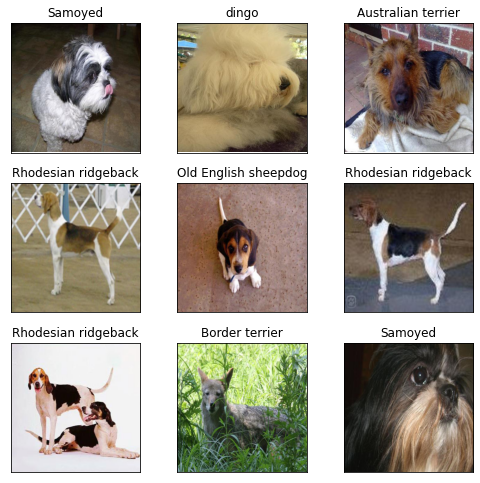

In [8]:
# Display a few training images
orig_train_dataiter = enumerate(orig_trainloader)
_, (orig_train_sample_data, orig_train_sample_targets) = next(orig_train_dataiter)

show_samples(orig_train_sample_data, orig_train_sample_targets)

tensor shape: (1000, 3, 320, 320)

min pixel value: 0.0
max pixel value: 1.0


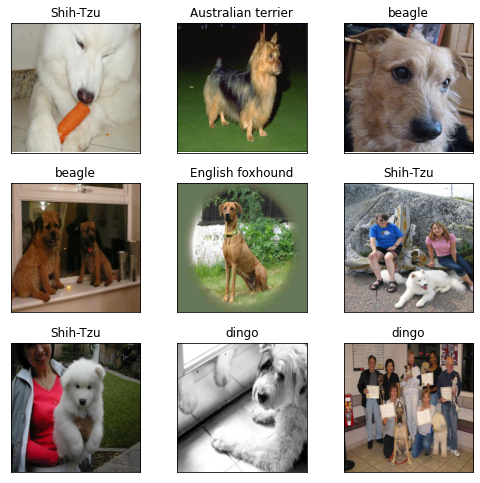

In [9]:
# Display a few test images
orig_test_dataiter = enumerate(orig_testloader)
_, (orig_test_sample_data, orig_test_sample_targets) = next(orig_test_dataiter)

show_samples(orig_test_sample_data, orig_test_sample_targets)

## Resize Data

In [10]:
def resize_data(data_path, size):
    for class_folder in data_path.iterdir():
        for image_file in class_folder.iterdir():
            with Image.open(image_file) as img:
                img_resized = img.resize((size,size))
                img_resized.save(image_file)

Before resizing the data we make a copy of the dataset to avoid destroying the original data.

In [11]:
# Data paths of original data copy folder and resized data folder
origcopy_dataset_path = Path(str(orig_dataset_path)+'-copy')
dataset_path = base_data_folder/fname_string

# Removing old folders and copy the original data folder
!rm -rf {str(dataset_path)}
!rm -rf {str(origcopy_dataset_path)}
!cp -r {str(orig_dataset_path)} {str(origcopy_dataset_path)}

In [12]:
# Data paths
origcopy_train_path = origcopy_dataset_path/'train'
origcopy_test_path = origcopy_dataset_path/'val'

# Resize the images of the training set
resize_data(origcopy_train_path, img_size)

# Resize the images of the test set
resize_data(origcopy_test_path, img_size)

After resizing we rename the folder according to the new size.

In [13]:
!mv {str(origcopy_dataset_path)} {str(base_data_folder/fname_string)}

In [14]:
# Data paths
train_path = dataset_path/'train'
test_path = dataset_path/'val'

# Training set
trainset = datasets.ImageFolder(
    root=str(train_path), transform=transforms.ToTensor()
)

# Test set 
testset = datasets.ImageFolder(
    root=str(test_path), transform=transforms.ToTensor()
)

# Create training dataloader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=1000, shuffle=True, num_workers=0
)

# Create test dataloader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1000, shuffle=True, num_workers=0
)

# Check size of training set and test set
train_size = len(trainloader.dataset)
test_size = len(testloader.dataset)

dataset_correct = (train_size == orig_train_size) and (test_size == orig_test_size)

print('dataset correct: {}'.format(dataset_correct))
print('trainset size: {}'.format(train_size))
print('testset size:  {}'.format(test_size))

dataset correct: True
trainset size: 9025
testset size:  3929


tensor shape: (1000, 3, 128, 128)

min pixel value: 0.0
max pixel value: 1.0


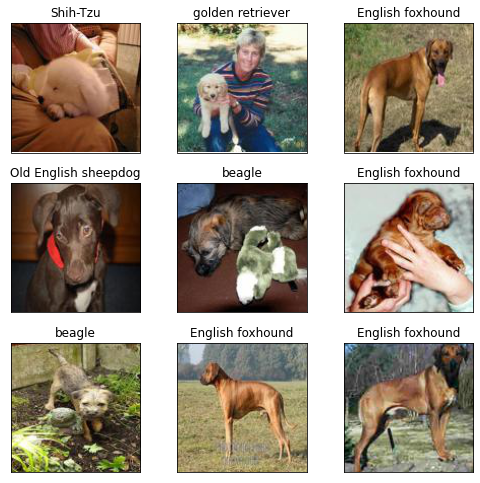

In [15]:
# Display a few training images
train_dataiter = enumerate(trainloader)
_, (train_sample_data, train_sample_targets) = next(train_dataiter)

show_samples(train_sample_data, train_sample_targets)

tensor shape: (1000, 3, 128, 128)

min pixel value: 0.0
max pixel value: 1.0


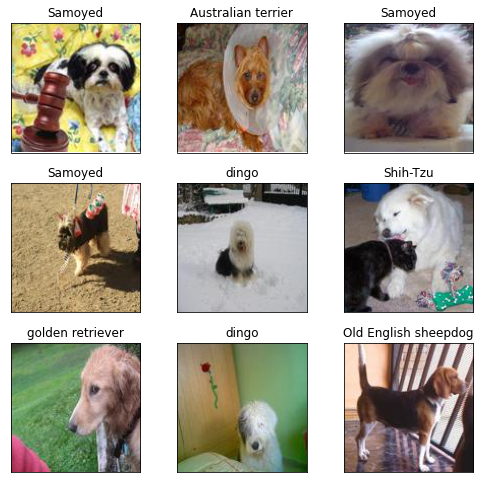

In [16]:
# Display a few test images
test_dataiter = enumerate(testloader)
_, (test_sample_data, test_sample_targets) = next(test_dataiter)

show_samples(test_sample_data, test_sample_targets)

## Store Images as Zip File

If we want to train our model using a GPU, we need to do that on the server as we only have access to a GPU there. To upload the dataset we need to compress it to a zip file first. Finally, we can upload it to the server and use it there for training the model.

In [17]:
# Remove old zip file and create new one
!rm -f {str(base_data_folder/fname_string)+'.zip'}
shutil.make_archive(str(base_data_folder/fname_string), 'zip', str(dataset_path))

'/Users/lehmann/research/laca3/datasets/imagewoof/imagewoof_128.zip'